In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [2]:
df_train = pd.DataFrame(pd.read_csv("./dataset/PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./dataset/PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/PR_HW3_Test.csv"))
# print(df_train.head())

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy().reshape(-1, 1)
X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy().reshape(-1, 1)
X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy().reshape(-1, 1)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

# Feature_names
feature_names = list(df_train[0:])
print(feature_names)

# Class_names
class_names_tmp = list(set(df_train['Target']))
class_names = []
for num in class_names_tmp:
    name = str(num)
    class_names.append(name)
print(class_names)

(800, 7)
(800, 1)
(800, 7)
(800, 1)
(800, 7)
(800, 1)
['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Target']
['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0']


# Model Implementation

In [3]:
def gini(sequence):
    unique_elements, counts = np.unique(sequence, return_counts=True)
    probabilities = counts / len(sequence)
    result = 1 - np.sum(probabilities ** 2)
    return result

def entropy(sequence):
    unique_elements, counts = np.unique(sequence, return_counts=True)
    probabilities = counts / len(sequence)
    result = (-1) * np.sum(probabilities * np.log2(probabilities))
    return result

In [4]:
class Leaf():
    def __init__(self, data):
        counts = {}
        for row in data :
            label = row[-1]
            if label not in counts:
                counts[label] = 0
            counts[label] = counts[label] + 1
        self.predictions = counts

class Decision_Node():
    def __init__(self, question, left_branch, right_branch, col, feature_importance):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.col = col
        self.feature_importance = feature_importance

class DecisionTree():
    def __init__(self, criterion='gini', max_features=None, max_depth=None, Plot_tree=False, show_procedure=False):
        self.criterion = criterion
        if max_depth is None:
            self.max_depth = 100000000   
        else:
            self.max_depth = max_depth + 1
        self.max_features = max_features 
        self.tree = None
        self.Plot_tree = Plot_tree
        self.show_procedure = show_procedure
        if criterion == 'gini':
            self.measure_func = gini
        if criterion == 'entropy':
            self.measure_func = entropy
        return None
    
    def partition(self, data, col, val):
        left_data, right_data = [], []
        for index in range(data.shape[0]):
            # Threshold = val
            if data[index, col] <= val:       
                left_data.append(data[index])
            else :
                right_data.append(data[index])
        left_data = np.array(left_data)
        right_data = np.array(right_data)
        return left_data, right_data
    
    def info_gain(self, left_data, right_data, current_uncertainty):
        p = float(len(left_data) / (len(left_data) + len(right_data)))
        return current_uncertainty - p * self.measure_func(left_data[:, -1]) - (1-p) * self.measure_func(right_data[:, -1])
    
    def find_best_split(self, data):
        X = data[:, 0:-1]    #(800,7)
        y = data[:, -1]      #(800,)
        n_samples, n_features = X.shape
        best_gain, best_col, best_feature_importance, best_question = 0, 0, 0, None
        current_uncertainty = self.measure_func(y)
        # For random forest
        if self.max_features is None:
            self.max_features = n_features
        attribute_indices = np.random.choice(n_features, size=int(self.max_features), replace=False)
        for col in attribute_indices:
            # Threshold calculation
            values = np.unique(X[:, col])
            values_copy = np.roll(np.copy(values), 1)                    
            values = 1/2 * (values + values_copy)
            values = values[1:]                        
            for val in values:                
                left_data, right_data = self.partition(data, col, val)
                # Pure split
                if (len(left_data) == 0 or len(right_data) == 0):
                    continue
                gain = self.info_gain(left_data, right_data, current_uncertainty)
                feature_importance = gain * len(data)
                if gain > best_gain :
                    best_gain, best_question, best_col = gain, val, col
                    best_feature_importance = feature_importance
        return best_gain, best_question, best_col, best_feature_importance

    def build_tree(self, data, depth):
        if depth+1 < self.max_depth:
            # Find best split
            best_gain, best_question, best_col, best_feature_importance = self.find_best_split(data)
            if self.show_procedure:
                print("====================================================================")
                print(f"Depth is {depth+1}\nThe question is {feature_names[best_col]} <= {best_question}\t Gain is {best_gain:.03f}\t Happend at col {best_col}")
            if best_gain == 0 :
                if self.show_procedure :
                    print(f"Found leaves")
                return Leaf(data)
            else:
                left_data, right_data = self.partition(data, best_col, best_question)
                left_branch = self.build_tree(left_data, depth+1)
                right_branch = self.build_tree(right_data, depth+1)
            return Decision_Node(best_question, left_branch, right_branch, best_col, best_feature_importance)
        else :
            if self.show_procedure:
                print(f"Found leaves")
            return Leaf(data)

    def fit(self, X, y, sample_weight=None):
        # print(f"=============================Start training=============================")
        # print(f"Training example shape {X.shape}")
        # print(f"Training lable shape {y.shape}")
        data = np.concatenate((X, y), axis = 1)
        depth = 0
        self.tree = self.build_tree(data, depth)
        if self.Plot_tree:
            print("===============================================")
            self.print_tree(self.tree)
        return self.tree
    
    def print_tree(self, node, spacing =""):
        if isinstance(node, Leaf):
            print (spacing + "Predict", node.predictions)
            return
        # Print the question at this node
        print (spacing + feature_names[node.col] + "<=" + str(node.question))
        # Call this function recursively on the true branch
        print (spacing + '--> Left:')
        self.print_tree(node.left_branch, spacing + "  ")
        # Call this function recursively on the false branch
        print (spacing + '--> Right:')
        self.print_tree(node.right_branch, spacing + "  ")

#---------------------------------------------------------------------------------------------------------------
    
    def classify(self, data, node):
        if isinstance(node, Leaf):
            #  A dictionary
            return node.predictions 
        else :
            col = node.col
            question = node.question
            if (data[col] <= question):
                return self.classify(data, node.left_branch)
            else :
                return self.classify(data, node.right_branch)
            
    def classify_prob(self, predictions):
        total = float(sum(predictions.values()))
        probs = {}
        for class_ in predictions.keys():
            probs[class_] = round(float(predictions[class_] / total), 3)
        return probs
    
    def predict(self, X): #########################################
        y_pred = []
        for i in range(len(X)):            
            max_pro = -1
            prediction = None
            predictions = self.classify_prob(self.classify(X[i], self.tree)) 
            # To meet sklearn standard
            for key in predictions:
                pre_prob = predictions[key]
                if pre_prob > max_pro :
                    max_pro = pre_prob                    
                    prediction = int(key)
                elif pre_prob == max_pro :
                    if (key < prediction) :
                        prediction = int(key)            
            # prediction = int(max(predictions, key=predictions.get))
            # if((X[i,0] > 752.5) and (X[i, 1] > 0.847) and (X[i, 1] <= 0.853)):
            #     print(predictions)
            y_pred.append(prediction)
        return y_pred
    
    def Get_feature_importance(self, node):
        dictonary = {}
        dictonary = self.Calculate_feature_importance(node, dictonary)        
        return dictonary
        
    def Calculate_feature_importance(self, node, dictonary) :
        if isinstance(node, Leaf):            
            return dictonary                
        if feature_names[node.col] not in dictonary:
            dictonary[feature_names[node.col]] = 0
        dictonary[feature_names[node.col]] += 1
        dictonary = self.Calculate_feature_importance(node.left_branch, dictonary)
        dictonary = self.Calculate_feature_importance(node.right_branch, dictonary)
        return dictonary
    

In [5]:
# clf_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3, Plot_tree=True, show_procedure=True)
# tree = clf_depth3.fit(X_train,y_train, sample_weight=None)
# acc_clf_depth3 = clf_depth3.count_acc(X_val, y_val, tree, show_every = False)
# clf_depth3_FI = clf_depth3.Get_feature_importance(tree)
# print(f"clf_depth3 accuracy is {acc_clf_depth3}")

In [6]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from sklearn import tree

# model = DecisionTreeClassifier(max_depth=3) #18:0.86625
# model.fit(X_train, y_train)
# y_predict = model.predict(X_val)
# print(accuracy_score(y_val, y_predict))

# text_representation = tree.export_text(model)
# print(text_representation)

# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(model, 
#                    feature_names=feature_names,  
#                    class_names=class_names,
#                    filled=True)
# plt.savefig("./answer.png")

In [7]:
class RandomForest():
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        if self.max_features is None:
            self.max_feature = int(np.sqrt(n_features))
        for i in range(self.n_estimators):
            print(f"-----------------------Processing forest {i}--------------------------")
            tree = DecisionTree(criterion=self.criterion, max_features=self.max_features, max_depth=self.max_depth, Plot_tree=False, show_procedure=False)
            if self.boostrap is True:
                idx = np.random.choice(n_samples, n_samples, replace=True)
                tree.fit(X[idx], y[idx])
                self.trees.append(tree)
            else: 
                tree.fit(X, y)
                self.trees.append(tree)

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):
            vote = []
            for j in range(self.n_estimators):
                cur_tree = self.trees[j]
                predictions = cur_tree.classify_prob(cur_tree.classify(X[i], cur_tree.tree))
                prediction = int(max(predictions, key=predictions.get))
                vote.append(prediction)
            predict, predict_count = np.unique(np.array(vote), return_counts=True)
            y_pred.append(predict[np.argmax(predict_count)])
        return y_pred

# Questions for Decision Tree

In [8]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])
print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [9]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73
np.random.seed(0) 
dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
tree = dt_depth3.fit(X_train, y_train, sample_weight=None)
acc = accuracy_score(y_val, dt_depth3.predict(X_val))
print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [10]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))
print(f"sk_acc = {sk_acc}")

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

sk_acc = 0.73125


In [11]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85
np.random.seed(0)
dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10, Plot_tree=False)
tree = dt_depth10.fit(X_train, y_train, sample_weight=None)
acc = accuracy_score(y_val,  dt_depth10.predict(X_val))
print("Q2-2 max_depth=10: ", acc)

Q2-2 max_depth=10:  0.865


In [12]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73
np.random.seed(0)
dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
tree = dt_gini.fit(X_train, y_train, sample_weight=None)
acc = accuracy_score(y_val, dt_gini.predict(X_val))
print("Q3-1 criterion='gini': ", acc)

Q3-1 criterion='gini':  0.73125


In [13]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77
np.random.seed(0)
dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
tree = dt_entropy.fit(X_train, y_train, sample_weight=None)
acc = accuracy_score(y_val, dt_entropy.predict(X_val))
print("Q3-2 criterion='entropy': ", acc)

Q3-2 criterion='entropy':  0.77


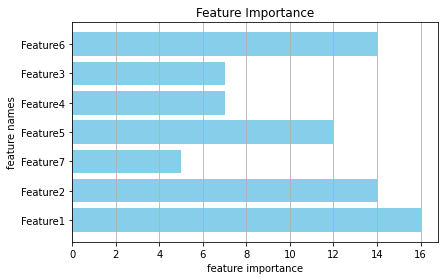

In [14]:
# For Q4
# Use simply counting to get the feature importance: dt_depth10.importance
# labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']
def show_Feature_Importance(feature_importance):
    plt.clf()
    plt.title("Feature Importance")
    plt.xlabel('feature importance')
    plt.ylabel('feature names')
    plt.gca().grid(axis = 'x', which = 'major')
    plt.tight_layout()
    FI = feature_importance.items()
    x, y = zip(*FI)
    plt.barh(x, y, color = 'skyblue')
    plt.show()

show_Feature_Importance(dt_depth10.Get_feature_importance(dt_depth10.tree))
    

# Questions for Random Rorest

In [15]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88
np.random.seed(0)
rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)
print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

-----------------------Processing forest 0--------------------------
-----------------------Processing forest 1--------------------------
-----------------------Processing forest 2--------------------------
-----------------------Processing forest 3--------------------------
-----------------------Processing forest 4--------------------------
-----------------------Processing forest 5--------------------------
-----------------------Processing forest 6--------------------------
-----------------------Processing forest 7--------------------------
-----------------------Processing forest 8--------------------------
-----------------------Processing forest 9--------------------------
Q6-1 n_estimators=10:  0.88875


In [16]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89
np.random.seed(0)
rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)
print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

-----------------------Processing forest 0--------------------------
-----------------------Processing forest 1--------------------------
-----------------------Processing forest 2--------------------------
-----------------------Processing forest 3--------------------------
-----------------------Processing forest 4--------------------------
-----------------------Processing forest 5--------------------------
-----------------------Processing forest 6--------------------------
-----------------------Processing forest 7--------------------------
-----------------------Processing forest 8--------------------------
-----------------------Processing forest 9--------------------------
-----------------------Processing forest 10--------------------------
-----------------------Processing forest 11--------------------------
-----------------------Processing forest 12--------------------------
-----------------------Processing forest 13--------------------------
-----------------------Process

In [17]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88
np.random.seed(0)
rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)
print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

-----------------------Processing forest 0--------------------------
-----------------------Processing forest 1--------------------------
-----------------------Processing forest 2--------------------------
-----------------------Processing forest 3--------------------------
-----------------------Processing forest 4--------------------------
-----------------------Processing forest 5--------------------------
-----------------------Processing forest 6--------------------------
-----------------------Processing forest 7--------------------------
-----------------------Processing forest 8--------------------------
-----------------------Processing forest 9--------------------------
Q7-1 max_features='sqrt':  0.88875


In [18]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86
np.random.seed(0)
rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)
print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

-----------------------Processing forest 0--------------------------
-----------------------Processing forest 1--------------------------
-----------------------Processing forest 2--------------------------
-----------------------Processing forest 3--------------------------
-----------------------Processing forest 4--------------------------
-----------------------Processing forest 5--------------------------
-----------------------Processing forest 6--------------------------
-----------------------Processing forest 7--------------------------
-----------------------Processing forest 8--------------------------
-----------------------Processing forest 9--------------------------
Q7-1 max_features='All':  0.88125


# Train your own model


---------------------------------Correlation---------------------------------
          Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
Feature1  1.000000  0.386341 -0.004138 -0.296028 -0.576868 -0.770774   
Feature2  0.386341  1.000000 -0.324435 -0.289485 -0.704998 -0.855532   
Feature3 -0.004138 -0.324435  1.000000  0.168631  0.310731  0.234297   
Feature4 -0.296028 -0.289485  0.168631  1.000000  0.630952  0.331842   
Feature5 -0.576868 -0.704998  0.310731  0.630952  1.000000  0.776966   
Feature6 -0.770774 -0.855532  0.234297  0.331842  0.776966  1.000000   
Feature7 -0.420099 -0.468541  0.127865  0.641411  0.469712  0.536559   
Target   -0.479764 -0.152386 -0.063878  0.329834  0.377533  0.286499   

          Feature7    Target  
Feature1 -0.420099 -0.479764  
Feature2 -0.468541 -0.152386  
Feature3  0.127865 -0.063878  
Feature4  0.641411  0.329834  
Feature5  0.469712  0.377533  
Feature6  0.536559  0.286499  
Feature7  1.000000  0.131676  
Target    0.131676  1.00

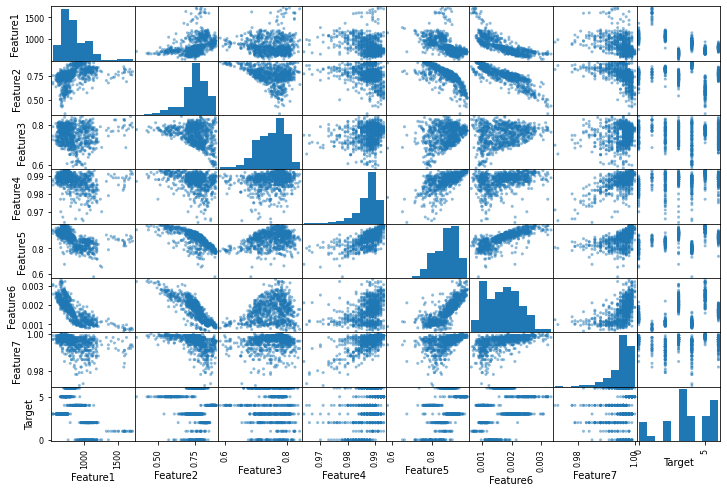


---------------------------------Data Info---------------------------------
   Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0     951.0     0.875     0.671     0.989     0.802  0.000969     0.996   
1     619.0     0.647     0.807     0.987     0.915  0.002760     0.996   
2     679.0     0.601     0.789     0.992     0.967  0.002640     0.999   
3     627.0     0.746     0.742     0.987     0.916  0.002220     0.997   
4     678.0     0.667     0.740     0.989     0.939  0.002410     0.998   

   Target  
0     4.0  
1     3.0  
2     5.0  
3     3.0  
4     3.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  800 non-null    float64
 1   Feature2  800 non-null    float64
 2   Feature3  800 non-null    float64
 3   Feature4  800 non-null    float64
 4   Feature5  800 non-null    float64
 5   Feature6  800 no

In [19]:
df_train = pd.DataFrame(pd.read_csv("./dataset/PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./dataset/PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/PR_HW3_Test.csv"))
print("\n---------------------------------Correlation---------------------------------")
print(df_train.corr())
from pandas.plotting import scatter_matrix
scatter_matrix(df_train, figsize=(12,8))
plt.show()
print("\n---------------------------------Data Info---------------------------------")
print(df_train.head(), "\n")
print(df_train.info(), "\n")
print(df_train.describe())

In [20]:
def Feature_engineering(data): 
#     data = 100 * (data - data.mean()) / data.std()
#     data['Feature1_mean'] = data['Feature1'].mean()
#     data['Feature2_mean'] = data['Feature2'].mean()
#     data['Feature3_mean'] = data['Feature3'].mean()
#     data['Feature4_mean'] = data['Feature4'].mean()
#     data['Feature5_mean'] = data['Feature5'].mean()
#     data['Feature6_mean'] = data['Feature6'].mean()
#     data['Feature7_mean'] = data['Feature7'].mean()
#     data['11'] = data['Feature1'] * data['Feature1']
#     data['22'] = data['Feature2'] * data['Feature2']
#     data['33'] = data['Feature3'] * data['Feature3']
#     data['44'] = data['Feature4'] * data['Feature4']
#     data['55'] = data['Feature5'] * data['Feature5']
#     data['66'] = data['Feature6'] * data['Feature6']
#     data['77'] = data['Feature7'] * data['Feature7']
#     for i in range(5):
#         data[str(i)] = data['Feature1']
#     print(data.head(5))
    return data

used_feature = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7'] 
target_feature = ['Target']
X_train = Feature_engineering(df_train[used_feature]).to_numpy()
X_val = Feature_engineering(df_val[used_feature]).to_numpy()
X_test = Feature_engineering(df_test[used_feature]).to_numpy()
y_train = df_train[target_feature].to_numpy().astype(int)
y_val = df_val[target_feature].to_numpy().astype(int)
print("X_train", X_train.shape)
print("X_val",  X_val.shape)
print("X_test",  X_test.shape)
print("y_train", y_train.shape)
print("y_val",  y_val.shape)

X_train (800, 7)
X_val (800, 7)
X_test (800, 7)
y_train (800, 1)
y_val (800, 1)


In [21]:
# Build and train your model
np.random.seed(6)
your_model = RandomForest(n_estimators=20, max_features=np.sqrt(X_train.shape[1]), 
                          boostrap=True, criterion='entropy', max_depth=15)
your_model.fit(X_train, y_train)
print("your_model validation accuracy: ", accuracy_score(y_val, your_model.predict(X_val)))

-----------------------Processing forest 0--------------------------
-----------------------Processing forest 1--------------------------
-----------------------Processing forest 2--------------------------
-----------------------Processing forest 3--------------------------
-----------------------Processing forest 4--------------------------
-----------------------Processing forest 5--------------------------
-----------------------Processing forest 6--------------------------
-----------------------Processing forest 7--------------------------
-----------------------Processing forest 8--------------------------
-----------------------Processing forest 9--------------------------
-----------------------Processing forest 10--------------------------
-----------------------Processing forest 11--------------------------
-----------------------Processing forest 12--------------------------
-----------------------Processing forest 13--------------------------
-----------------------Process

In [22]:
test_pred = np.array(your_model.predict(X_test))
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [23]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("109550090_prediction.csv")

In [24]:
# class Tree():
#     """
#         You can add/change any variables/methods to meet your need.
#     """
#     def __init__(self):       
#         pass
    
# class DecisionTree():
#     def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
#         """
#             You can add/change any variables/methods to meet your need.
#         """

#         if criterion == 'gini':
#             self.criterion = gini
#         elif criterion == 'entropy':
#             self.criterion = entropy
        
#         if max_depth is None:
#             self.max_depth = 1e9
#         else:
#             self.max_depth = max_depth

#         self.importance = {}

#     def fit(self, X, y):
#         pass

#     def predict(self, X):
#         pass

#     def countImportance(self):
#         pass